In [1232]:
import numpy as np
import matplotlib.pyplot as plt

In [1233]:
T = 100
n = 10
alpha = 0.9
beta = 0.2
gamma = 0.1
Lambda = [1,5]
cpd_z = [1-alpha,alpha,0.5]
Gamma = np.array(
    [
        [1-gamma,0,gamma],
        [0,1-gamma,gamma],
        [beta/2,beta/2,1-beta]
    ]
)



In [1234]:
# Since numpy doesn't have built in support for categorical distribution
def categorical(distribution: np.array):
    # returns the result of a single sample drawn from a binomial distribution <distribution> 
    sample = np.random.multinomial(1,distribution)
    res = np.where(sample)[0][0]
    return res

In [1235]:
# Simulate

C = np.zeros(T,dtype='int32')
Z = np.zeros((T,n),dtype='int32')
X = np.zeros((T,n),dtype='int32')
C[0] = 2
for t in range(T):
    if t == 0:
        pass
    else:
        C[t] = categorical(Gamma[C[t-1]])
    Z[t] = np.random.binomial(1,cpd_z[C[t]],size=n)
    for i in range(n):
        X[t][i] = np.random.poisson(Lambda[Z[t][i]])

    


Text(0.5, 0, 't')

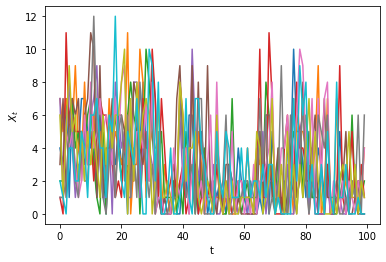

In [1236]:
for i in range(n):
    plt.plot(X[0:,i])
plt.ylabel(r'$X_{t}$')
plt.xlabel('t')


In [1237]:
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0).fit(X,C)


In [1238]:
C

array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [1239]:
coin = lambda p, size=None: np.random.binomial(1, p, size=size)
poisson = lambda p, x : np.exp(-p)*(p**x)/np.math.factorial(x)

px = np.array([[poisson(p_,x_) for p_ in (1,5)] for x_ in range(20)])
px

T = 100
n = 10
alpha = 0.9
beta = 0.2
gamma = 0.1
Lambda = [1,5]
cpd_z = np.array([
    [alpha, 1-alpha],
    [1-alpha,     alpha],
    [0.5, 0.5]
    ])

Gamma = np.array(
    [
        [1-gamma,0,gamma],
        [0,1-gamma,gamma],
        [beta/2,beta/2,1-beta]
    ]
)

In [1240]:
%%latex
$$\psi^t = \psi(C^t,C^{t+1}) = P(C^{t+1}|C^t) = \Gamma $$
$$\phi_i^t = \sum_{Z_i^t}\psi(C^t,Z_i^t,X_i^t) = \sum{Z_i^t}P(Z_i^t|C^t)P(x_i^t|Z_i^t)$$
$$\tau^t = \sum_{C^{t-i}} \psi^{t-1}\tau^{t-1}\prod_{i=1}^n \phi_i^{t-1}$$
$$\tau_0 = P(C_0) = [0,0,1]$$
$$\theta^t = \psi^{t-1}\tau^{t-1}\prod_{i=1}^n \phi_i^{t-1}$$

<IPython.core.display.Latex object>

In [1241]:
c = np.zeros(T)

taus = np.zeros((T,3))
tau = np.array([0,0,1])
taus[0] = tau
thetas = np.zeros((T,3,3))

for t in range(1,T):
    # multiply incoming messages (phi)
    phi = 1
    for i in range(0,n):
        phi *= px[X[t][i]]
    # this step is equivalent to marginalizing
    phi = cpd_z @ phi
    # calculate theta and store
    theta = Gamma * tau * phi
    thetas[t] = theta
    # calculate tau by marginalizing C
    tau = np.sum(theta,axis=1)
    # normalize tau
    tau /= np.sum(tau)
    taus[t] = tau
    


In [1242]:
# check the likelihood of encountering C^T given x^0:T
taus[T-1][C[T-1]]

0.81346692222099

In [1243]:
# backwards pass 
taus_ = np.zeros((T,3))
tau_ = np.sum(thetas[T-1],axis=1)
tau_ /= np.sum(tau_)
taus_[T-1] = tau_
betas = np.zeros((T,3,3))
cpd_cs = np.zeros((T,3))
cpd_cs[0] = [0,0,1]

for t in range(T-1,0,-1):
    # multiply incoming messages (phi)
    beta = thetas[t]*tau_
    betas[t] = beta
    # marginalize
    cpd_c = np.sum(betas[t],axis=1)
    cpd_c /= np.sum(cpd_c)
    cpd_cs[t] = cpd_c
    # calculate tau_
    tau_ = cpd_c
    taus_[t] = tau_


In [1257]:
cpd_cs[np.arange(len(cpd_cs)),C]

array([1.        , 0.8       , 0.39946879, 0.70977778, 0.82132309,
       0.86028304, 0.87580623, 0.88255884, 0.88563561, 0.88707001,
       0.88774534, 0.88805668, 0.88812204, 0.88736731, 0.11786493,
       0.17786703, 0.85597358, 0.87396772, 0.88173337, 0.88525396,
       0.88689098, 0.88766173, 0.88802682, 0.88820026, 0.88828277,
       0.88832199, 0.88834019, 0.88834428, 0.88830226, 0.8878599 ,
       0.88361165, 0.148274  , 0.34080769, 0.20514006, 0.55803465,
       0.74459699, 0.79254612, 0.74749038, 0.52729712, 0.68465396,
       0.57578873, 0.49575312, 0.55211906, 0.32803863, 0.25144575,
       0.28731289, 0.47320596, 0.25558041, 0.57651286, 0.72097592,
       0.72777381, 0.36806675, 0.77963896, 0.84493503, 0.12674204,
       0.87972634, 0.88432773, 0.88645762, 0.88745689, 0.8879279 ,
       0.88813697, 0.88809871, 0.88676786, 0.8737653 , 0.21738944,
       0.57917908, 0.62173664, 0.70789072, 0.65283098, 0.65957708,
       0.53254798, 0.6710488 , 0.76765328, 0.75678371, 0.35729

In [1254]:
len(cpd_cs)

100